# Credit Card Default at NuBank

One of the most important areas for banks is understanding what facotrs into a client defaulting on a loan.  This is the puzzle for every bank in the world today.  

To determine if a customer will default on a loan, we will analyze key features about a customer.  This will help minimize default risks for banks.  

By definition, a default is the failure to make required interest or principal repayments on a debt.  A typical default would be a customer can't make their payment on a mortgage loan.  


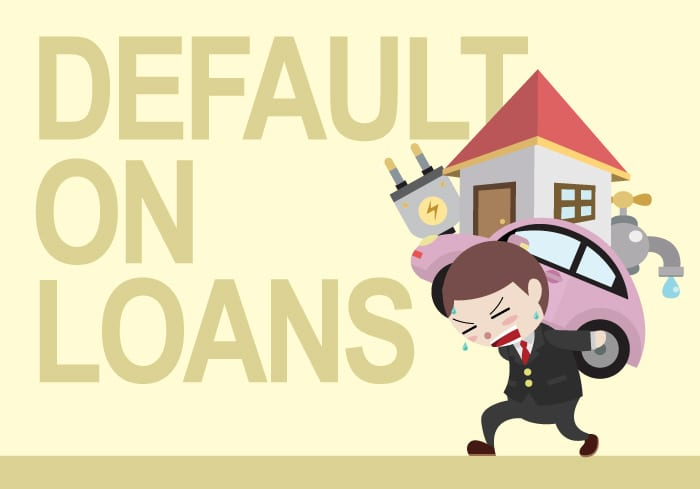


**Goal: To create a model that provides the probability of credit card default for a customer**

This model is expected to be able to decrease the company's financial losses while minimizing false positives

## Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report

# random seed
np.random.seed(42)

sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

## Read in our Data

In [2]:
df = pd.read_csv('Acquisition_train.csv')
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


#### Data Dictionary

- ids
- 

## Exploratory Data Analysis

In [3]:
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,...,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,...,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,...,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,...,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,...,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,...,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,...,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,...,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


In [4]:
#Checks for any null values
df.isna().sum()

ids                                                     0
target_default                                       3259
score_1                                               562
score_2                                               562
score_3                                               562
score_4                                                 0
score_5                                                 0
score_6                                                 0
risk_rate                                             562
last_amount_borrowed                                29956
last_borrowed_in_months                             29956
credit_limit                                        13800
reason                                                566
income                                                562
facebook_profile                                     4458
state                                                 562
zip                                                   562
channel       

#### Check Null Percentage per column

From the above data, we have quite a few null columns.  Therefore, we need to check the percentage of null within each column

In [5]:
print((df.isnull().sum() / df.shape[0]).sort_values(ascending=False))

target_fraud                                        0.966178
last_amount_borrowed                                0.665689
last_borrowed_in_months                             0.665689
ok_since                                            0.589889
external_data_provider_credit_checks_last_2_year    0.502844
external_data_provider_credit_checks_last_year      0.336089
credit_limit                                        0.306667
n_issues                                            0.256533
facebook_profile                                    0.099067
marketing_channel                                   0.079511
job_name                                            0.074133
target_default                                      0.072422
external_data_provider_email_seen_before            0.049622
lat_lon                                             0.030289
user_agent                                          0.016044
n_bankruptcies                                      0.015489
n_defaulted_loans       

Insights from above:

- Some variables may end up getting discarded as the variables are over 50% NULL
- Variables (external_data_provider_redit_checks_last_year, credit_limit, n_issues) have 25% - 34% of their values missing

In [6]:
df.dtypes

ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip                                     

## Proportion of Defaults within the dataset

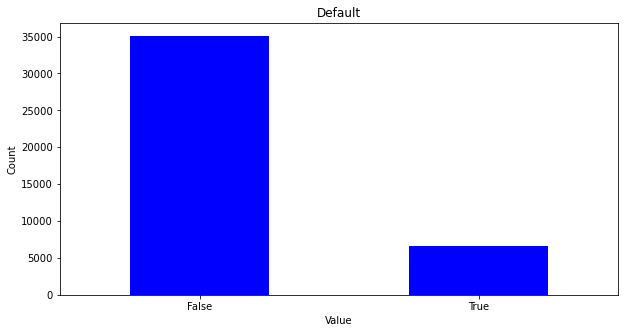

In [15]:
fig = plt.figure(figsize = (10,5))

counts = df['target_default'].value_counts()
counts.plot(kind='bar', color = 'blue', align = 'center')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Default')
plt.show()

As we would expect, the majority of this dataset consists of good banking loans and only 15% of defaults

### Preparing the Data

#### Create a copy of the dataframe

In [10]:
df1 = df.copy()

#### Replace the infinite values with NaN

In [13]:
df1['reported_income'] = df1['reported_income'].replace(np.inf, np.nan)

#### Dropping unnecessary columns

- Ids are not relevant for our model
- Target_fraud is not related to this project

In [14]:
df1.drop(['ids', 'target_fraud', 'external_data_provider_credit_checks_last_2_year', 'channel'], axis=1, inplace=True)

In [17]:
df1.loc[df1['external_data_provider_email_seen_before'] == -999.0, 'external_data_provider_email_seen_before'] = np.nan

#### Clean up the missing data

- Replacing missing numerical values with the median
- Replacing missing categorical values with the most frequent

In [21]:
from sklearn.impute import SimpleImputer

#Splits the dataframe into numerical and categorical
numerical_df = df1.select_dtypes(exclude = 'object').columns
categorical_df = df1.select_dtypes(include = 'object').columns

#Substitute missing values
df1.last_amount_borrowed.fillna(value=0, inplace=True)
df1.last_borrowed_in_months.fillna(value=0, inplace=True)
df1.n_issues.fillna(value=0, inplace=True)

#numerical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df1.loc[:, numerical_df])
df1.loc[:, numerical_df] = imputer.transform(df1.loc[:, numerical_df])

#Categorical Variables
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df1.loc[:, categorical_df])
df1.loc[:, categorical_df] = imputer.transform(df1.loc[:, categorical_df])

#### Remove Null values in the target_default field

In [22]:
df1.dropna(subset=['target_default'], inplace=True)
df1.head(5)

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,...,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
0,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,...,leidelaura,645.0,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528.0,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,...,diocezio,243.0,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933.0,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...
2,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,...,veralucia,65.0,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985.0,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...
3,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,...,venice,815.0,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825.0,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...
4,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,...,darzisa,320.0,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827.0,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...


Without knowledge around some of the features, we can assume that some of the NaN values are due to:
    
1. Some items are not mandatory when filling out a form
2. There is no observation regarding some columns



#### Checks for NULL Values

In [27]:
df1.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
reason                                             0
income                                             0
facebook_profile                                   0
state                                              0
zip                                                0
job_name                                           0
real_state                                         0
ok_since                                      

#### Create another copy of our data prior to visualizations


In [26]:
df2 = df1.copy()
df2.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,...,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,4.500000e+04,45000.000000,...,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,4.500000e+04,45000.000000
mean,347.883556,100.006797,0.500037,99.925228,0.296633,4607.590065,13.962133,31703.232800,7.147825e+04,33.258933,...,0.004511,10.688000,8.228778,247.537000,1.501067,0.670289,28.045356,500.399800,1.031004e+13,33923.514844
std,109.740995,3.178080,0.288326,10.016549,0.101298,8005.393392,20.574767,30729.712314,5.154691e+04,13.954793,...,0.078894,4.564351,6.250257,146.118398,1.114941,0.470113,17.356466,287.968873,2.557745e+14,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,0.000000,0.000000,0.000000,4.821180e+03,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,4.030000e+02,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,0.000000,0.000000,17419.000000,4.501474e+04,32.000000,...,0.000000,7.000000,0.000000,120.000000,1.000000,0.000000,13.000000,252.000000,5.094825e+04,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,0.000000,0.000000,25647.000000,6.126676e+04,32.000000,...,0.000000,10.000000,9.000000,248.000000,2.000000,1.000000,28.000000,503.000000,1.016300e+05,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,7525.775000,36.000000,35719.250000,8.503822e+04,32.000000,...,0.000000,13.000000,12.000000,375.000000,2.000000,1.000000,43.000000,747.000000,1.511462e+05,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,...,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,6.355500e+15,56000.000000


#### Encode the Categorical Variables 

In [29]:
from sklearn.preprocessing import LabelEncoder
encoded_df = df2.copy()
cat_columns = encoded_df.select_dtypes('object').columns
bool_columns = encoded_df.select_dtypes('bool').columns
for col in cat_columns:
    encoded_df[col+'_encoded'] = LabelEncoder().fit_transform(encoded_df[col])
    encoded_df.drop(col, axis=1, inplace=True)
    
for col in bool_columns:
    encoded_df[col+'_encoded'] = LabelEncoder().fit_transform(encoded_df[col])
    encoded_df.drop(col, axis=1, inplace=True)

In [30]:
encoded_df.head(5)

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,...,email_encoded,external_data_provider_first_name_encoded,lat_lon_encoded,marketing_channel_encoded,profile_phone_number_encoded,shipping_state_encoded,profile_tags_encoded,user_agent_encoded,target_default_encoded,facebook_profile_encoded
0,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,32.0,...,4,19930,15025,2,27910,12,17167,86,0,1
1,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,50.0,...,0,7792,6981,5,11504,20,21553,33,0,0
2,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25647.0,65023.65,32.0,...,0,31062,14899,7,9945,19,6993,81,1,0
3,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,32.0,...,5,31036,5114,7,12265,17,19975,123,0,0
4,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25647.0,60011.29,32.0,...,0,6609,4539,2,191,12,25813,142,0,1


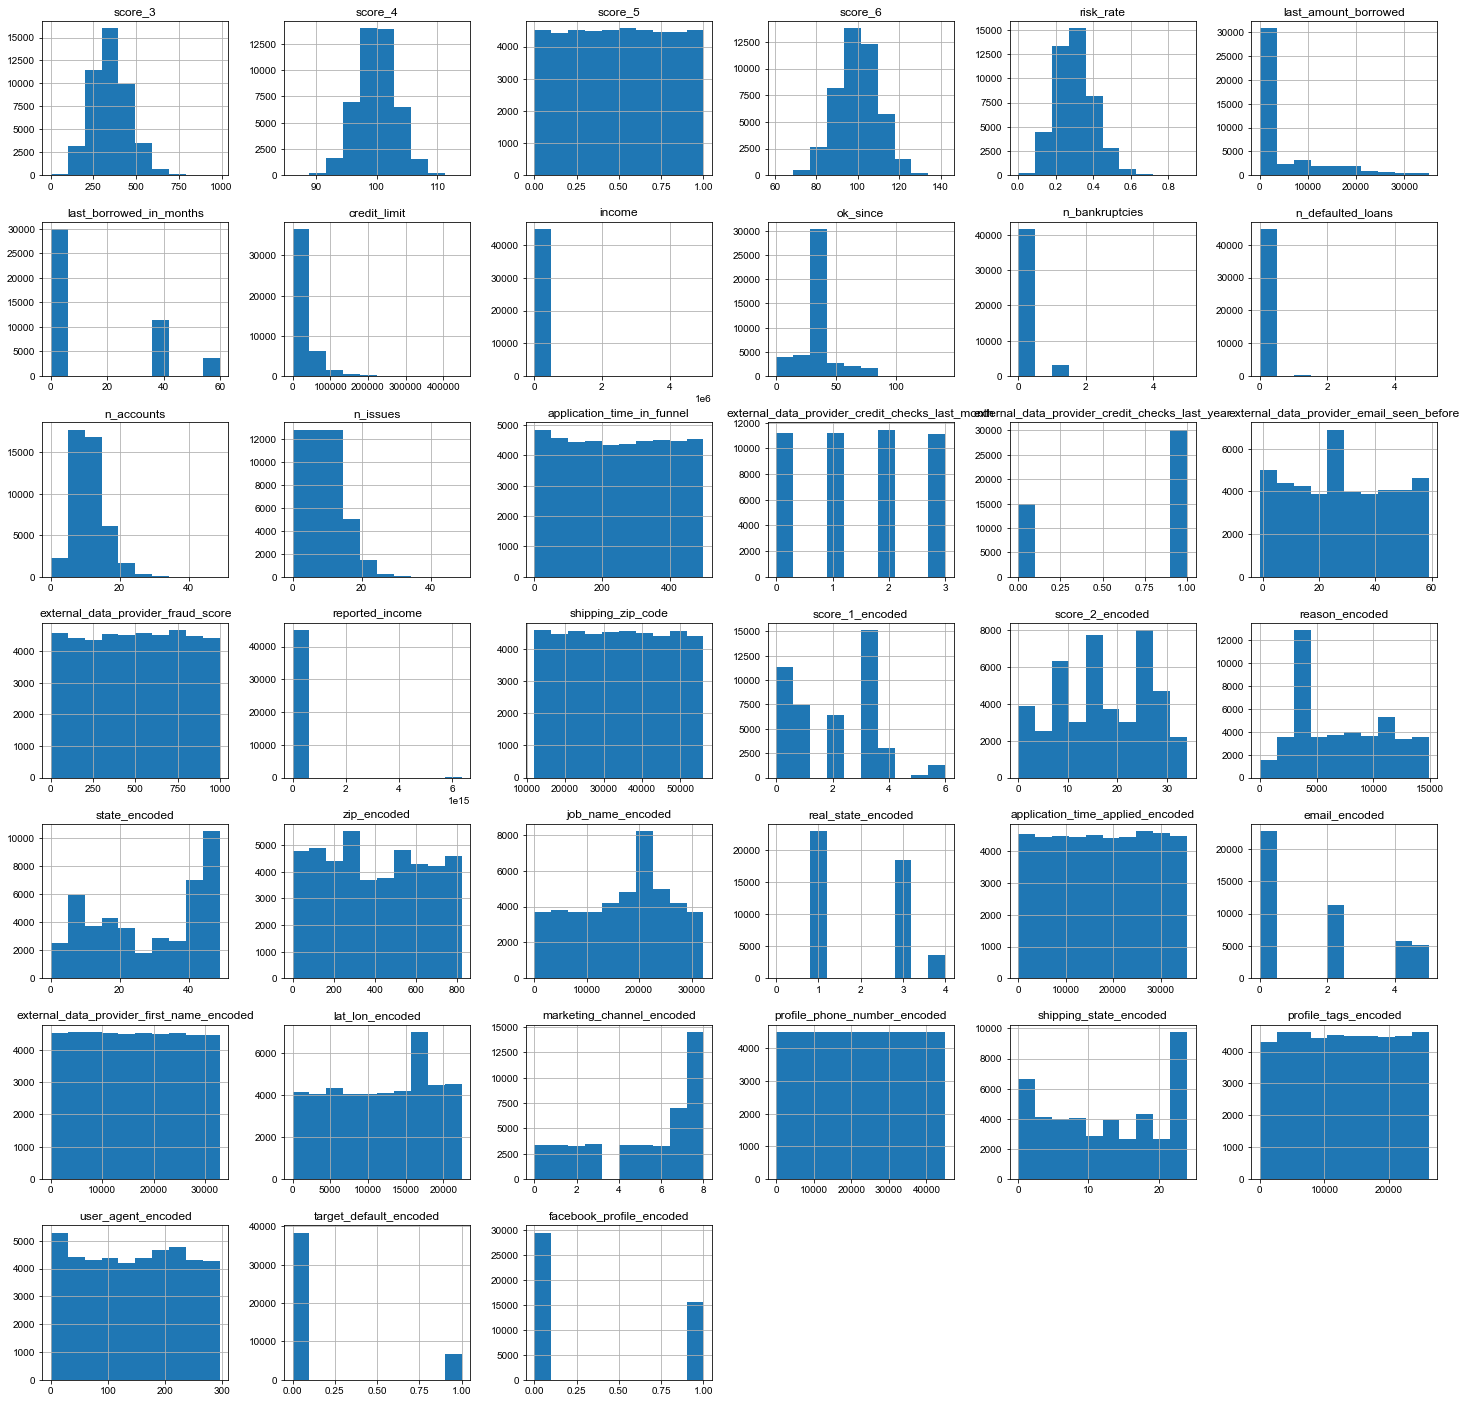

In [31]:
encoded_df.hist(figsize=(25,25))
sns.set()

<AxesSubplot:xlabel='income', ylabel='credit_limit'>

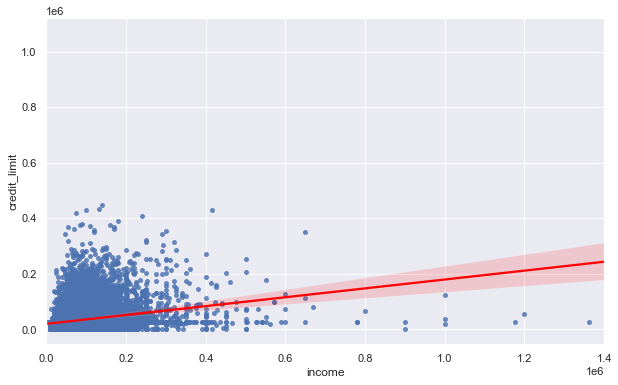

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlim(left=-1000,right=1400000)
sns.regplot('income', 'credit_limit', scatter_kws={"s":15}, line_kws={"color":"red"}, data=encoded_df, ax=ax)

0.0    0.996133
1.0    0.003378
2.0    0.000378
3.0    0.000089
5.0    0.000022
Name: n_defaulted_loans, dtype: float64


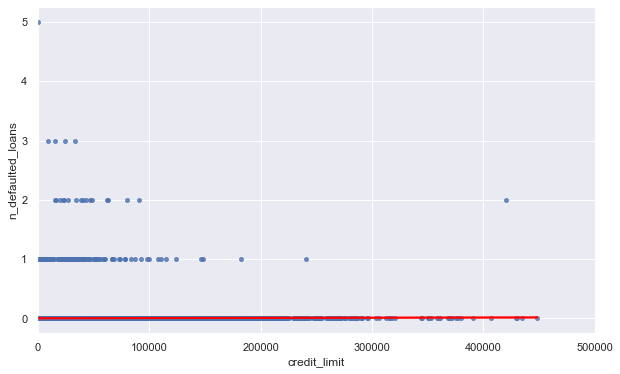

In [37]:
#Check the distribution of Defaults within the dataset
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim(left=-1000,right=500000)
sns.regplot('credit_limit', 'n_defaulted_loans', scatter_kws={"s":15}, line_kws={'color':"red"}, data=encoded_df, ax=ax)
print(encoded_df['n_defaulted_loans'].value_counts() / encoded_df.shape[0])


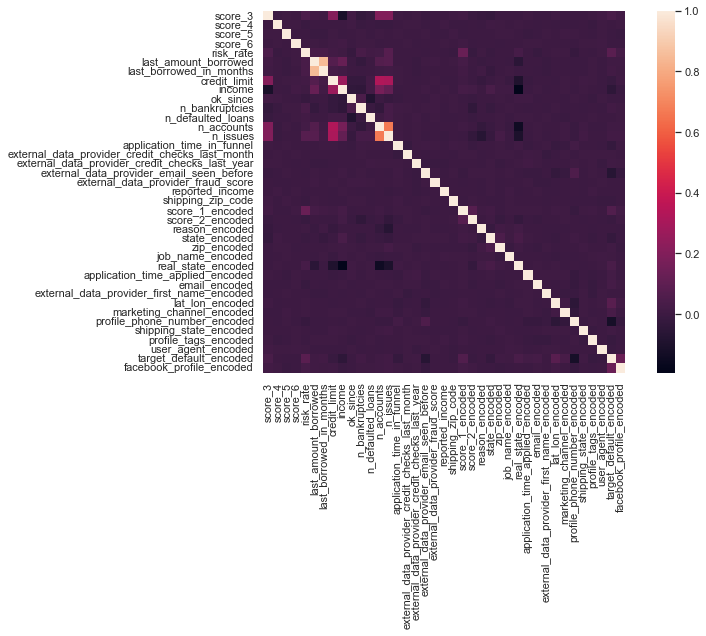

In [38]:
corr = encoded_df.corr()

f,ax = plt.subplots(figsize = (12,9))

sns.heatmap(corr, fmt='.2f', square=True, linecolor='white', vmax=1.0, annot=False)
plt.tight_layout()

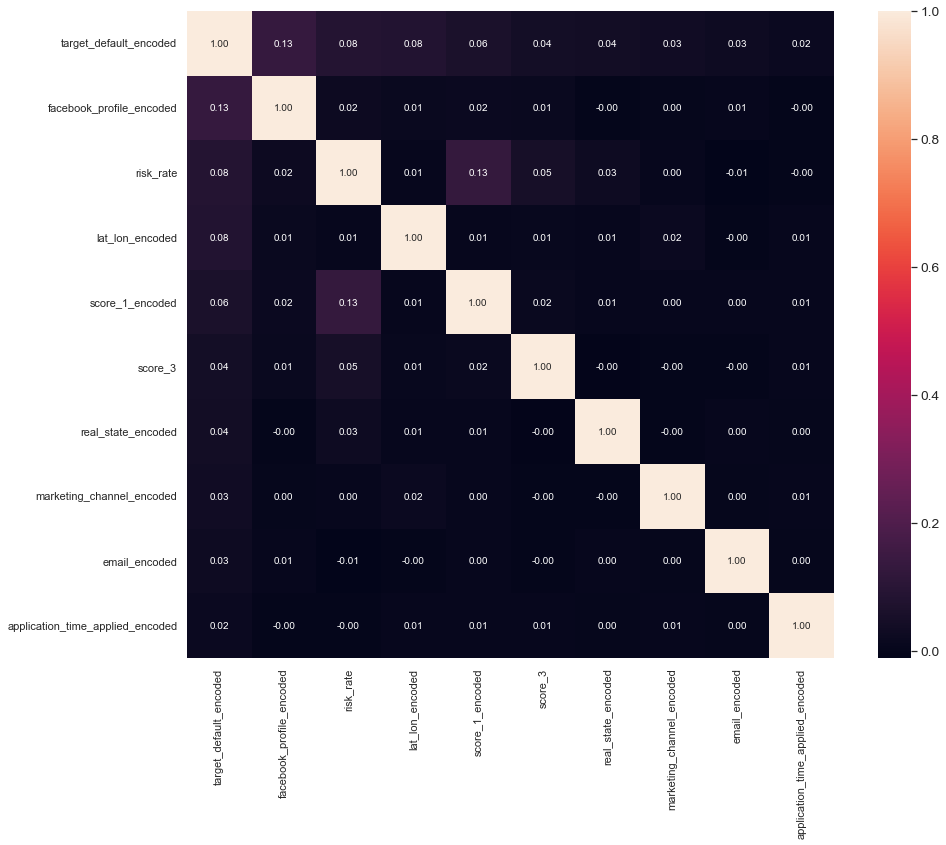

In [40]:
#Select a number of variables to look at
k = 10

cols = corr.nlargest(k, 'target_default_encoded')['target_default_encoded'].index
cm = np.corrcoef(encoded_df[cols].values.T)

#Plotting a heatmap with these 10 variables
f, ax = plt.subplots(figsize = (15,12))
sns.set(font_scale = 1.254)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values,
                xticklabels=cols.values)
plt.tight_layout()

#### Insights from the Heatmap

- There are some correlations that are logical, but not relevant for our model
- facebook_profile_encoded is the most correlated variable to the target_default
- Anticipated that the risk_rate would be a relevant variable, but the level of correlation is low


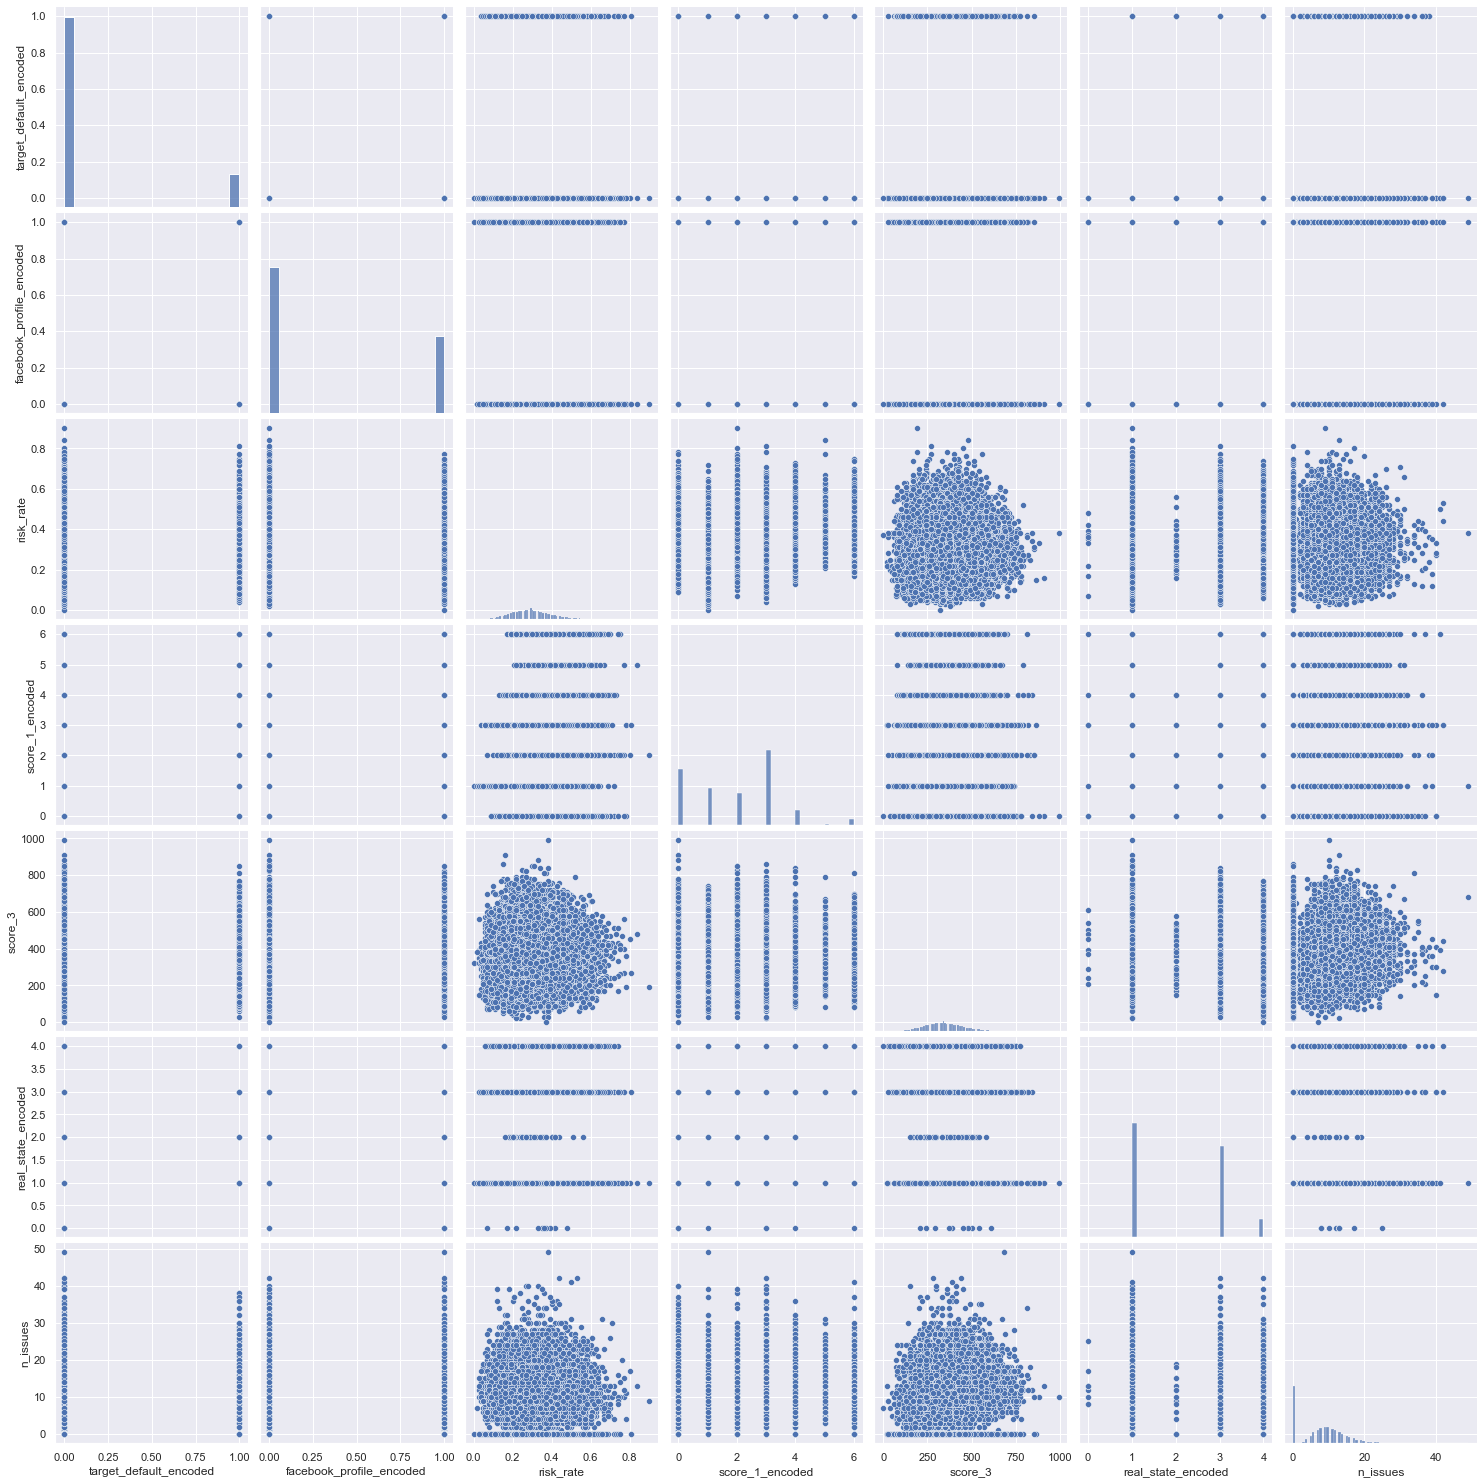

In [41]:
sns.set()
cols = ['target_default_encoded', 'facebook_profile_encoded', 'risk_rate', 'score_1_encoded', 'score_3', 'real_state_encoded', 'n_issues']
sns.pairplot(encoded_df[cols], height=4, size=(3))
plt.show()

#### Visualization Insights

- Weak correlations between the target variables and other variables
- Most correlated variables are the unexpected variables
- Number of previous loans defaulted highly influence credit limit
- Higher income doesn't mean higher credit limit

## Machine Learning

The goal is to maximize the accuracy of our model and minimize the number of false positives

#### Scale the numerical Variables

In [42]:
from sklearn.preprocessing import StandardScaler

scaled_df = df1.copy()
numerical_cols = scaled_df.drop('target_default', axis=1).select_dtypes(exclude='object').columns
scaled_df[numerical_cols] = StandardScaler().fit_transform(scaled_df[numerical_cols].values)

#### Scale the Categorical Variables

In [43]:
encoded_df = scaled_df.copy()
categorical_cols = encoded_df.select_dtypes('object').columns
for col in categorical_cols:
    encoded_df[col + '_encoded'] = LabelEncoder().fit_transform(encoded_df[col])
    encoded_df.drop(col, axis=1, inplace=True)

In [44]:
encoded_df.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,...,real_state_encoded,application_time_applied_encoded,email_encoded,external_data_provider_first_name_encoded,lat_lon_encoded,marketing_channel_encoded,profile_phone_number_encoded,shipping_state_encoded,profile_tags_encoded,user_agent_encoded
0,False,0.019286,0.564509,-0.834072,0.848809,1.020438,2.551599,1.071123,-1.031692,-0.125404,...,1,32643,4,19930,15025,2,27910,12,17167,86
1,False,0.201535,-0.926413,1.535143,-0.790968,-0.559085,-0.575567,-0.678612,0.261078,0.553689,...,1,24841,0,7792,6981,5,11504,20,21553,33
2,True,0.110411,0.006380,-0.513727,1.294594,-0.065484,0.324826,1.071123,-0.197083,-0.125219,...,3,31,0,31062,14899,7,9945,19,6993,81
3,False,1.477281,0.501153,1.691282,-0.501449,0.230676,-0.575567,-0.678612,0.744817,-0.051376,...,3,4397,5,31036,5114,7,12265,17,19975,123
4,False,1.386156,-0.482217,0.112727,1.817111,-1.151406,-0.575567,-0.678612,-0.197083,-0.222459,...,3,7418,0,6609,4539,2,191,12,25813,142


#### Split the dataset

In [45]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

X = encoded_df.drop('target_default', axis=1).select_dtypes(exclude='object')
y = encoded_df['target_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)
print(model.feature_importances_)

[0.0286018  0.02930178 0.02860741 0.02882947 0.02978434 0.01935232
 0.01983483 0.02645078 0.02863794 0.02118958 0.02508718 0.01059279
 0.00126333 0.02813115 0.02775586 0.03095561 0.02574102 0.01479795
 0.03447657 0.02855165 0.00143982 0.02937916 0.03731166 0.0306219
 0.02927127 0.02979816 0.02951872 0.02913172 0.01594392 0.02957234
 0.0244705  0.02894244 0.03698859 0.0258623  0.04603949 0.02859676
 0.03083474 0.02833315]


In [47]:
feature_importances = pd.DataFrame(model.feature_importances_, index = X_train.columns,
                                  columns=['importance']).sort_values('importance', ascending=False)
feature_importances.reset_index(inplace=True)
feature_importances.rename(columns={'index':"features"}, inplace=True)

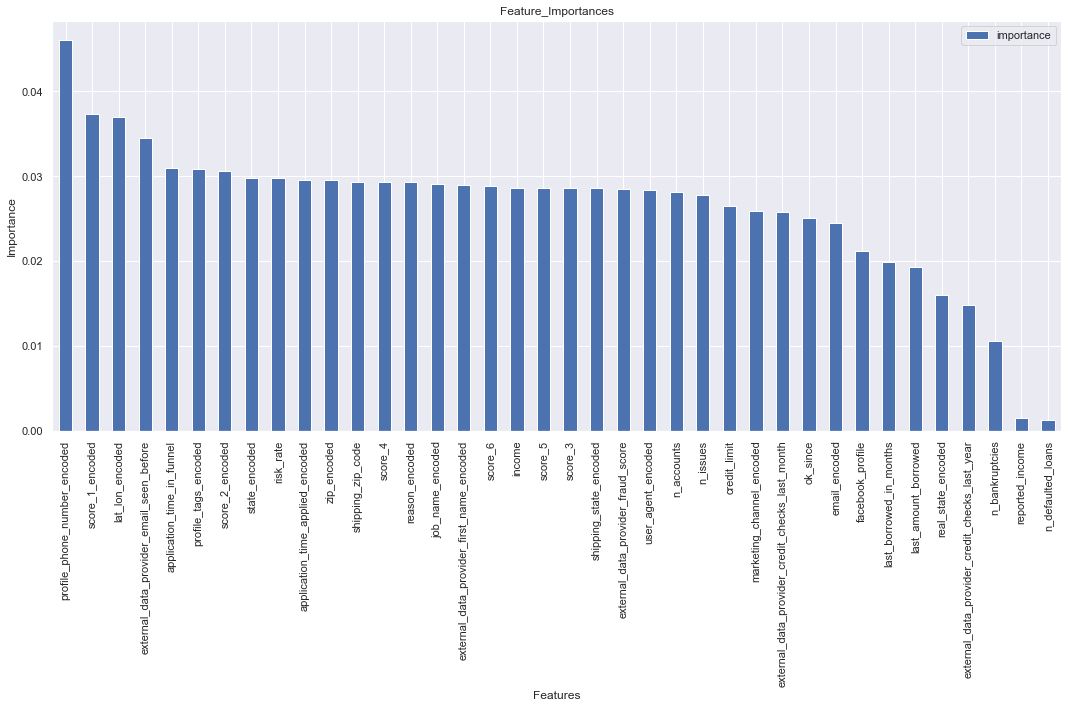

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
feature_importances.plot(x='features', y='importance', kind='bar', ax=ax)
ax.set_title('Feature_Importances')
ax.set_xlabel('Features')
ax.set_ylabel("Importance")
plt.tight_layout()

In [49]:
df_ml = encoded_df[['profile_phone_number_encoded','lat_lon_encoded', 'score_1_encoded', 
                   'external_data_provider_email_seen_before', 'application_time_applied_encoded', 'risk_rate',
                   'profile_tags_encoded', 'score_2_encoded', 'user_agent_encoded', 'application_time_in_funnel',
                   'shipping_zip_code', 'job_name_encoded', 'zip_encoded', 'score_6', 'score_5', 'reason_encoded']]
df_ml['target_default'] = encoded_df['target_default']

In [50]:
X = df_ml.drop('target_default', axis=1).select_dtypes(exclude='object')
y = df_ml['target_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

False    4663
True     4663
Name: target_default, dtype: int64


<AxesSubplot:xlabel='target_default', ylabel='count'>

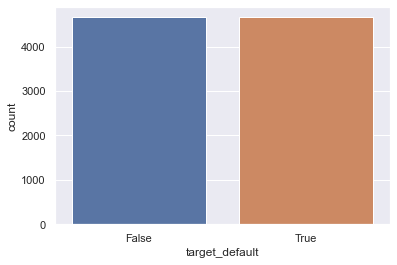

In [53]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(pd.Series(y_rus).value_counts())

sns.countplot(y_rus)

In [54]:
def val_model(X, y, clf, quite=False):
    X = np.array(X)
    y = np.array(y)
    
    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring = 'recall')
    
    if quite == False:
        print("Recall: {:.4f} (+/-{:.2f})".format(scores.mean(), scores.std()))
        
    return scores.mean()

rf = RandomForestClassifier()
score_baseline = val_model(X_rus, y_rus, rf)

Recall: 0.5696 (+/-0.02)


In [56]:
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []

for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train, y_train, clf, quite=True))
    
pd.DataFrame(data=recall, index=model, columns=['recall'])

[LightGBM] [Info] Number of positive: 3731, number of negative: 21469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3227
[LightGBM] [Info] Number of data points in the train set: 25200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148056 -> initscore=-1.749934
[LightGBM] [Info] Start training from score -1.749934
[LightGBM] [Info] Number of positive: 3731, number of negative: 21469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3230
[LightGBM] [Info] Number of data points in the train set: 25200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148056 -> initscore=-1.749934
[LightGBM] [Info] Start training from score -1.749934
[LightGBM] [In

,recall
RandomForestClassifier,0.057904
DecisionTreeClassifier,0.257778
SGDClassifier,0.000000
SVC,0.000000
LogisticRegression,0.000643
XGBClassifier,0.129533
LGBMClassifier,0.104441


In [57]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [58]:
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [4,10,15],
    'ccp_alpha': [0.0, 0.5, 1.0],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1,5,10]
}

kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(dt, param_grid, scoring="recall", n_jobs = -1, cv=kfold)
grid_result = grid_search.fit(X_rus, y_rus)

print("Melhor: {:.2f} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.58 para {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 10}


In [59]:
ml_model = DecisionTreeClassifier(ccp_alpha=0.0, max_depth=5, criterion='gini', random_state=42)
ml_model.fit(X_rus, y_rus)

DecisionTreeClassifier(max_depth=5, random_state=42)

Classification Report:
               precision    recall  f1-score   support

       False     0.9025    0.6665    0.7668     11502
        True     0.2337    0.5856    0.3341      1998

    accuracy                         0.6545     13500
   macro avg     0.5681    0.6260    0.5504     13500
weighted avg     0.8035    0.6545    0.7027     13500

Accuracy Score:	 0.6545

ROC_AUC:	 0.6260



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

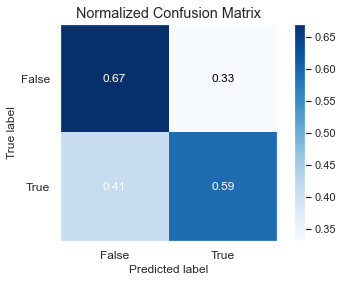

In [62]:
y_pred = ml_model.predict(X_test)

#Classification Report
print('Classification Report:\n', classification_report(y_test, y_pred, digits=4))

#Accuracy
print("Accuracy Score:\t {:.4f}\n".format(accuracy_score(y_test,y_pred)))

#AUC
print('ROC_AUC:\t {:.4f}\n'.format(roc_auc_score(y_test, y_pred)))

#confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

## Conclusions

We were able to get a baseline for this model, but our models could benefit from some tweeks.  Whether that would be other types of encoding, another way of balancing the data, feature engineering, etc.  This project is far from perfect as we are still providing credit to people who shouldn't have it, and denying it to people who should have it.  Nevertheless, it gives us a baseline to start. 

